In [72]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

In [73]:
meta = pd.read_csv("series-networks/meta.csv")
edgelist = pd.read_csv("series-networks/walkingdead/edges.csv")
attr = pd.read_csv("series-networks/walkingdead/attributes.csv")

In [74]:
# Extract substring
attr["medium"] = attr["id"].str.extract(r'\((.*?)\)')
attr["medium"].unique()

array(['TV_Series', 'Road_to_Survival', '2000', 'All-Stars',
       'Casino_Slots', 'Comic_Series', 'Lands', 'March_to_War',
       'Match_3_Tales', 'No_Man%27s_Land', 'Sandbox', 'Small_Bites',
       'Survivors', 'The_Escapists', 'Telltale', nan, 'Daryl_Series',
       'Assault', 'Last_Mile', 'Empires', 'Our_World', 'Fear',
       'Social_Game', 'Saints_%26_Sinners', 'World_Beyond',
       'Survival_Instinct', 'Overkill', 'TV_Universe', 'Novel_Series',
       'Alexandria', 'PADRE', 'Terminus', 'Onslaught', 'Stalker',
       'Alone,_Together', 'Tales', 'Dead_in_the_Water',
       'Clementine_Series', 'Red_Machete', 'Dead_City', 'A_New_World',
       'Issue_193', 'Destinies', 'Webisodes', 'Hilltop', 'Marauder',
       'Woodbury', 'Here%27s_Negan', 'Made_to_Suffer', 'The_Best_Defense',
       'House_Of_Memories', 'The_Reason', 'Flight_462', 'Something_Bad',
       'This_Ain%27t_It', 'The_Alien', 'Pathways', 'Priya%27s_Story',
       'Radio_Waves', 'Negan_Lives', 'The_Ones_Who_Live',
    

TV seriesre utalhat
- TV_Series
- TV_Universe -> 21
- vannak még külön évadok is benne -> mx. 3-4

Comic
- Comic_Series

In [75]:
tv_attr = attr[attr["medium"] == "TV_Series"]
com_attr = attr[attr["medium"] == "Comic_Series"]

# Add Zombies
tv_attr.loc[len(tv_attr.index)] = attr.iloc[-1]
com_attr.loc[len(com_attr.index)] = attr.iloc[-1]

# Set medium column for Zombies to tv/comic 
tv_attr.loc[tv_attr["medium"].isna(), "medium"] = "TV_Series"
com_attr.loc[com_attr["medium"].isna(), "medium"] = "Comic_Series"

C:\Users\aronn\AppData\Local\Temp\ipykernel_16756\2687955711.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_attr.loc[len(tv_attr.index)] = attr.iloc[-1]
C:\Users\aronn\AppData\Local\Temp\ipykernel_16756\2687955711.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_attr.loc[len(com_attr.index)] = attr.iloc[-1]


Négy ábrás összehasonlítást csinálni:
- Mennyire összetartó a network (akár alábbi kettővel közösen csinálni?)
- Karakterek / kapcsolatok száma
- Halálok száma -> külön charton, mivel sok kategória van
- Hogyan kapcsolódik a két network?
- Legfontosabb karakterek összehasonlítás
- Kapcsolatok zombikkal, hány van (leosztva teljes fokszámmal) -> csak a Zombie node (van walker is?)
- Megnéz változók

In [76]:
# From and to are in respective attribute or either one is "Zombies" and other is in attr
com_edgelist = edgelist[(edgelist["from"].isin(com_attr["id"]) &
                        edgelist["to"].isin(com_attr["id"])) |
                        (((edgelist["from"] == "Zombies") &
                        edgelist["to"].isin(com_attr["id"])) |
                        (edgelist["from"].isin(com_attr["id"])) &
                        (edgelist["to"] ==  "Zombies"))]

tv_edgelist = edgelist[(edgelist["from"].isin(tv_attr["id"]) &
                        edgelist["to"].isin(tv_attr["id"])) |
                        (((edgelist["from"] == "Zombies") &
                        edgelist["to"].isin(tv_attr["id"])) |
                        (edgelist["from"].isin(tv_attr["id"])) &
                        (edgelist["to"] ==  "Zombies"))]

### Id-k javítása (ne legyen benne ...(TV_Series))

In [77]:
com_attr["id2"] = com_attr["id"].str.split("_(Comic_Series)").str[0]
tv_attr["id2"] = tv_attr["id"].str.split("_(TV_Series)").str[0]

# for now we don't modify the ids in edgelists "from" and "to" cols

C:\Users\aronn\AppData\Local\Temp\ipykernel_16756\2693199943.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_attr["id2"] = com_attr["id"].str.split("_(Comic_Series)").str[0]
C:\Users\aronn\AppData\Local\Temp\ipykernel_16756\2693199943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_attr["id2"] = tv_attr["id"].str.split("_(TV_Series)").str[0]


### Create network

In [78]:
tv_g = nx.from_pandas_edgelist(tv_edgelist, "from", "to", create_using=nx.DiGraph)
com_g = nx.from_pandas_edgelist(com_edgelist, "from", "to", create_using=nx.DiGraph)

### Number of characters and edges

In [80]:
categories = ["TV series", "TV series", "Comic", "Comic"]
values = [len(tv_attr), nx.density(tv_g), len(com_attr), nx.density(com_g)]
names = ["Characters", "Edge density"] * 2

n_chars_edges = pd.DataFrame({"category": categories, "values": values, "names": names})
n_chars_edges

,category,values,names
0,TV series,811.00000,Characters
1,TV series,0.02068,Edge density
2,Comic,342.00000,Characters
3,Comic,0.05517,Edge density


Változtatások?
- rárakni, hogy mennyire összetartó/teljes a network
- kiemelni különbséget?

Next 90%
- Display value

# Hogyan lehet megoldani a plot problémáját
https://stackoverflow.com/questions/51882279/seaborn-barplot-with-two-y-axis

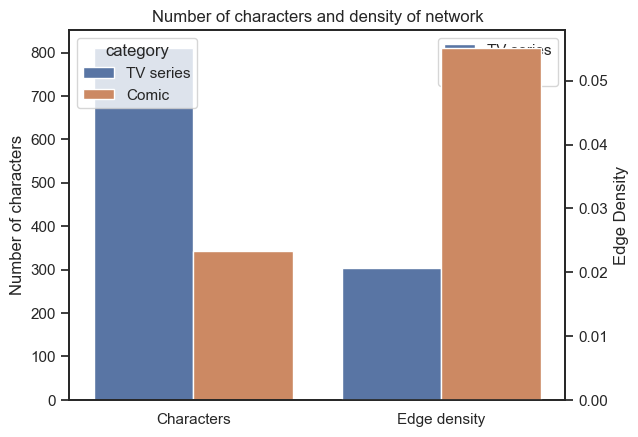

In [180]:
fig, ax1 = plt.subplots()

# Plot the main bars
sns.barplot(x='names', y='values', hue='category', data=n_chars_edges[n_chars_edges['names'] == 'Characters'], ax=ax1)
ax1.set_title('Number of characters and density of network')
ax1.set_xlabel('')
ax1.set_ylabel('Number of characters')
ax1.legend(title=None)

# Create a secondary y-axis for edge density
ax2 = ax1.twinx()
# Plot the edge density values on the secondary y-axis
sns.barplot(x='names', y='values', hue='category', data=n_chars_edges[n_chars_edges['names'] == 'Edge density'], ax=ax2)
ax2.set_ylabel('Edge Density')

#plt.savefig("walknig_dead1.png")

plt.show()

### Most important nodes

In [82]:
tv_attr.loc[:, "eigen_cent"] = tv_attr["id"].map(pd.Series(nx.eigenvector_centrality(tv_g)))
com_attr.loc[:, "eigen_cent"] = com_attr["id"].map(pd.Series(nx.eigenvector_centrality(com_g)))

C:\Users\aronn\AppData\Local\Temp\ipykernel_16756\3019255934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_attr.loc[:, "eigen_cent"] = tv_attr["id"].map(pd.Series(nx.eigenvector_centrality(tv_g)))
C:\Users\aronn\AppData\Local\Temp\ipykernel_16756\3019255934.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  com_attr.loc[:, "eigen_cent"] = com_attr["id"].map(pd.Series(nx.eigenvector_centrality(com_g)))


In [107]:
important_com = com_attr.sort_values(by="eigen_cent", ascending=False).head(5)[["name", "eigen_cent", "medium"]]
important_tv = tv_attr.sort_values(by="eigen_cent", ascending=False).head(5)[["name", "eigen_cent", "medium"]]

important = pd.concat([important_tv, important_com])

order = important["name"].tolist()
important

,name,eigen_cent,medium
810,Zombies,0.316919,TV_Series
2028,Gabriel Stokes,0.195233,TV_Series
15,Aaron,0.172099,TV_Series
1848,Eugene Porter,0.171680,TV_Series
4630,Rosita Espinosa,0.162646,TV_Series
341,Zombies,0.249027,Comic_Series
4508,Rick Grimes,0.242520,Comic_Series
274,Andrea Grimes,0.208653,Comic_Series
908,Carl Grimes,0.200601,Comic_Series
3613,Michonne Hawthorne,0.199229,Comic_Series


C:\Users\aronn\AppData\Local\Temp\ipykernel_16756\765309216.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30, ha='right')
C:\Users\aronn\AppData\Local\Temp\ipykernel_16756\765309216.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30, ha='right')


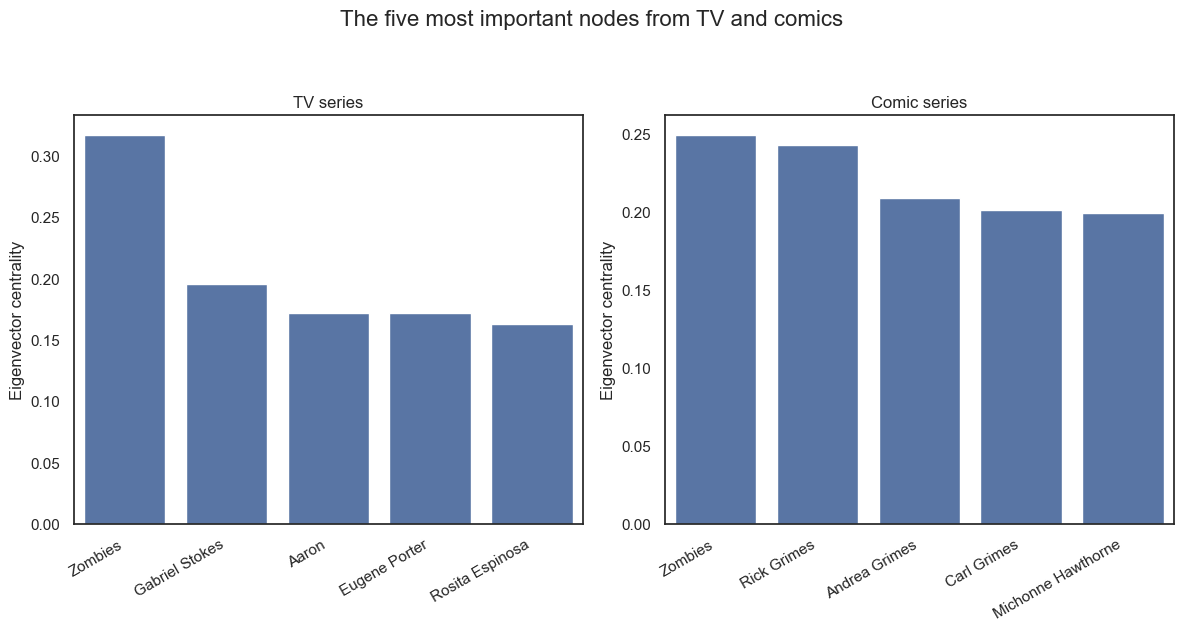

In [183]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sns.barplot(x="name", y="eigen_cent", data=important[important["medium"] == "TV_Series"], ax=axs[0])
axs[0].set_title('TV series')
axs[0].set_xlabel('')
axs[0].set_ylabel('Eigenvector centrality')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30, ha='right') 

sns.barplot(x="name", y="eigen_cent", data=important[important["medium"] == "Comic_Series"], ax=axs[1])
axs[1].set_title('Comic series')
axs[1].set_xlabel('')
axs[1].set_ylabel('Eigenvector centrality')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30, ha='right') 

fig.suptitle('The five most important nodes from TV and comics', y=1.05, fontsize=16)

plt.tight_layout()

#plt.savefig("walknig_dead3.png")

plt.show()

### Status variable

In [170]:
pd.set_option('display.max_columns', None)


tv_unique_status = tv_attr["status"].unique().tolist()
com_unique_status = com_attr["status"].unique().tolist()
print(tv_unique_status)
print(com_unique_status)

valid_status = ["Dead", "Alive", "Undead", "Unknown"]

# Create dfs with valid status values
tv_attr_val_stat = tv_attr[tv_attr["status"].isin(valid_status)]
com_attr_val_stat = com_attr[com_attr["status"].isin(valid_status)]

tv_stat_share = tv_attr_val_stat["status"].value_counts(normalize=True)
com_stat_share = com_attr_val_stat["status"].value_counts(normalize=True)

# Put share series' into df


com_stat_share.round(2)

['Dead', 'Alive', 'Disbanded', 'Unknown', 'Dissolved', nan, 'Undead', 'Active', 'Inactive', 'Destroyed']
['Alive', 'Dead', "Inactive; Merged with the Rick's Group", 'Unknown', 'Inactive', 'Undead', nan, 'Active', "Inactive; Merged with Rick's Group", 'Disbanded', 'Disbanded; Merged with the Commonwealth Army']


status
Dead       0.49
Unknown    0.35
Alive      0.11
Undead     0.05
Name: proportion, dtype: float64

In [171]:
joined_share = pd.DataFrame({"Dead": [0.68, 0.49],
                             "Unknown": [0.21, 0.35],
                             "Alive": [0.07, 0.11],
                             "Undead": [0.03, 0.05]},
                             index = ["TV_Series", "Comic_Series"])

Text(0, 0.5, 'Share')

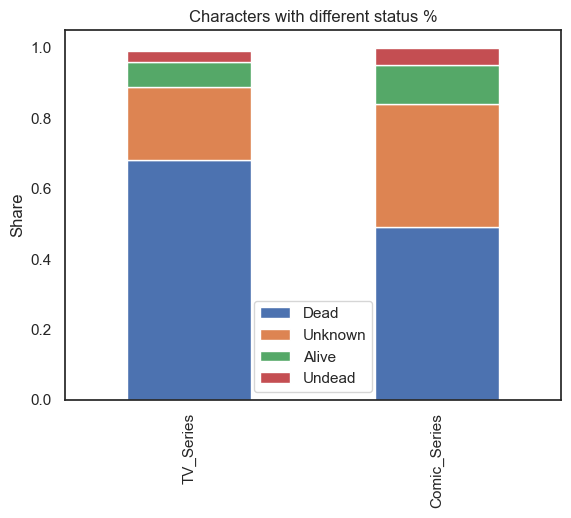

In [185]:
joined_share.plot(kind='bar', stacked=True)

plt.title("Characters with different status %")
plt.ylabel("Share")

#plt.savefig("walknig_dead2.png")


### Ethnicity

In [178]:
tv_attr["ethnicity"].unique()

array(['Caucasian-American', nan, 'Mexican-American', 'Unknown',
       'African-American', 'Latino-American',
       'African/Caucasian-American', 'African/Asian-American',
       'African/Samoan-American', 'Middle Eastern-American',
       'Irish-American', 'Indian-American', 'Native-American', 'Horse',
       'Asian-American', 'Irish', 'Latina-American',
       'African/Latino-American', 'Asian/Caucasian-American',
       'Unspecified', 'Caucasian/African-American', 'Belgian Malinois',
       'French-American', 'Native/African-American', 'Italian-American',
       'Korean-American', 'Latino/African-American',
       'African/Hispanic-American', 'Canine',
       'Caucasian-American (Assumed)', 'Samoan-American',
       'Caucasian/Pacific Islander-American', 'Puerto Rican-American',
       'Mexican', 'Latina/Irish-American', 'Hispanic-American', 'Varies',
       'Mexican-American[1]', 'Felidae', 'Arab-American',
       'Mexican[2]/Arab-American', 'French/Caucasian-American',
       'C

In [177]:
tv_attr

,id,name,image,actor,gender,hair,age,occupation,family,ethnicity,status,deathimage,type,leader,series,tvdeathimage,comicdeathimage,location,episode,allies,enemies,merged,only,image2,death,image3,state,tv_image,irl,medium,id2,eigen_cent
0,A.J._Ford_(TV_Series),A.J. Ford,NaN,Drake Ethan Light,Male,Red,10,Pre-ApocalypseAssumed Elementary School Student,Ellen Ford - Mother †Abraham Ford - Father †Be...,Caucasian-American,Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV_Series,A.J._Ford_(TV_Series),0.002758
15,Aaron_(TV_Series),Aaron,NaN,Ross Marquand,Male,Brown,"Early 30s (""Them"")Late 30s (""Who Are You Now?""...",Pre-ApocalypseFormer PoliticianNGO WorkerPost-...,(Unnamed) - Mother †(Unnamed) - Brother †(Unna...,Caucasian-American,Alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV_Series,Aaron_(TV_Series),0.172099
42,Abraham_Ford_(TV_Series),Abraham Ford,NaN,Michael Cudlitz,Male,Red,Late 40s,Pre-ApocalypseSergeant for the U.S ArmyPost-Ap...,Ellen Ford - Late Wife †A.J. Ford - Son †Becca...,Caucasian-American,Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV_Series,Abraham_Ford_(TV_Series),0.116872
44,Abraham%27s_Group_(TV_Series),Abraham's Group,"Eugene, Abraham, and Rosita",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Disbanded,NaN,Survivors,Abraham Ford,TV Series,NaN,NaN,NaN,"""Inmates"" to ""Coda""",NaN,Unknown,Rick's Group,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV_Series,Abraham%27s_Group_(TV_Series),0.037103
46,Abuela_(TV_Series),Abuela,NaN,Gina Morelli,Female,Gray,Early 80s,Pre-ApocalypseRetiree/Pensioner,Felipe - Grandson †Miguel - Grandson †,Mexican-American,Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV_Series,Abuela_(TV_Series),0.023518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5918,Zach_(TV_Series),Zach,NaN,Kyle Gallner,Male,Brown,Late Teens to Early 20s,Pre-ApocalypseCollege StudentPost-ApocalypseSu...,Beth Greene - Girlfriend †,Caucasian-American,Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV_Series,Zach_(TV_Series),0.027194
5930,Zell_(TV_Series),Zell,NaN,Terrence James,Male,Black,Late 20s to Early 30s,Post-ApocalypseSoldier for the Commonwealth Army,Livits - Late Lover †,African-American,Alive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV_Series,Zell_(TV_Series),0.006252
5933,Zia_(TV_Series),Zia,NaN,Ciera L. Payton,Female,Brown,Early to Mid 30s,Unknown,Unknown,African-American,Dead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV_Series,Zia_(TV_Series),0.014078
5934,Zion_(TV_Series),Zion,NaN,David Ury,Male,Brown,Early 40s,Unknown,Unknown,Caucasian-American,Undead,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TV_Series,Zion_(TV_Series),0.009892


### Zombik

Check, hogy máshogy is vannak e benne zombik?

In [13]:
edgelist[(edgelist["from"] == "Zombies") |
         (edgelist["to"] ==  "Zombies")]
len(edgelist)

72746